In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys 
import numpy as np
sys.path.append('/home/alexabades/recsys')


In [2]:
datapath = "../data/raw/frappe/frappe.csv"
df = pd.read_csv(datapath, sep="\t")
datapath = "../data/raw/frappe/"
meta_app = pd.read_csv(datapath +'meta.csv', sep="\t")
df_meta = df.merge(meta_app, on='item')
# d = PreProcessData(datapath)

In [1]:
import sys 
import numpy as np

sys.path.append('/home/alexabades/recsys')
from src.data.Contextual import PreProcessDataNCFContextual
datapath = "../data/raw/frappe/"
df_frappe = PreProcessDataNCFContextual(datapath)

In [2]:
df_frappe.clean_data['user'].unique().max(), len(df_frappe.clean_data['user'].unique())

(888, 651)

In [3]:
user_id = df_frappe.data.user.unique()
item_id = df_frappe.data.item.unique()

In [4]:
train_user_id = df_frappe.train_ratings.user.unique()
train_item_id = df_frappe.train_ratings.item.unique()

In [5]:
print('train: ',np.all(np.isin(train_user_id, user_id)))
print("test", np.all(np.isin(train_item_id, item_id)))

train:  True
test True


In [142]:
df = pd.DataFrame({
    'userID': [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
    'itemID': [0, 1, 0, 2, 3, 4, 1, 5, 2, 4, 3, 5],
})

num_interactions_by_user = df.groupby('userID').count()
num_interaction_by_item = df.groupby('itemID').count()

idx_test = [0, 2, 4, 6, 8, 10]
idx_train = [1, 3, 5, 7, 9, 11]

In [152]:
test = set(df[np.isin(df.index, idx_test)]['itemID'].unique())
train = set(df[np.isin(df.index, idx_train)]['itemID'].unique())

test - train, train -test

({0, 3}, {4, 5})

In [150]:
print("test: ", df[np.isin(df.index, idx_test)]['itemID'].unique())
print("train: ",df[np.isin(df.index, idx_train)]['itemID'].unique())


test:  [0 3 1 2]
train:  [1 2 4 5]


In [141]:
df[]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

I have some troubles achieveing a train test split for my dataset in recomendation sistems. 
If I am dealing with sparse data, where I have some items and users with low interaction. Do we have to ensure in the train test split that at least 1 item/user appears at least once in the train and test set? 
This problem may occur also with datasets with more interactions, but in order to ilustarte in a simple example, I'll create a small dataset: 

Example:

df = pd.DataFrame({
    'userID': [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
    'itemID': [0, 1, 0, 2, 3, 4, 1, 5, 2, 4, 3, 5],
})

If we check the num of iteraction by user and the times an item has been interacted: 

num_interactions_by_user = df.groupby('userID').count()
num_interaction_by_item = df.groupby('itemID').count()

num of iteraction by user
userID     count       
0            2
1            2
2            2
3            2
4            2
5            2

num times an item has been interacted
itemID     count   
0            2 <br>
1            2
2            2
3            2
4            2
5            2

We can see that some of our samples have only 2. If we wish to train test split kind of randomly we can do something like:
for i in df.userID.unique():
   test_idx = df.userID.random(1)

The problem of this approach is that we may end up with some items only in the test set, which is not obtimal. For example 

Being the index of the dataframe idx = list(df.index) we could en up with:
idx_test = [0, 2, 4, 6, 8, 10]
idx_train = [1, 3, 5, 7, 9, 11]

We can see that in this case the test set will end up like:

    userID  itemID
0        0       0
2        1       0
4        2       3
6        3       1
8        4       2
10       5       3

And the train set like:

    userID  itemID
1        0       1
3        1       2
5        2       4
7        3       5
9        4       4
11       5       5

And wheras we might have been able to add at least one user in each set we fail to add at least one item both sets.

df[np.isin(df.index, idx_test)]['itemID'].unique() = [0 3 1 2]
df[np.isin(df.index, idx_train)]['itemID'].unique() = [1 2 4 5]

We fail to add itemIDs 0 and 3 in the train set and we fail to add the itemIDs 4 and 5 in the test set. I believe that missing some items in the test set won't supose that much trouble. But if we miss one items in the train set we could face the cold start problem for that specific Item, as the model would not have seen this item in the training process.

In [153]:
import pandas as pd
import numpy as np

# Define the DataFrame
df = pd.DataFrame({
    'userID': [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
    'itemID': [0, 1, 0, 2, 3, 4, 1, 5, 2, 4, 3, 5],
})

# Create empty lists to hold the indices for the train and test sets
idx_train = []
idx_test = []

# Loop through each user to ensure they appear in both sets
for user_id in df['userID'].unique():
    user_interactions = df[df['userID'] == user_id]
    
    # Ensure at least one interaction per user goes into each set
    train_interaction = user_interactions.sample(n=1, random_state=42)  # Sample one interaction for training
    test_interaction = user_interactions.drop(train_interaction.index)  # Use the other for testing
    
    # Append indices to the appropriate lists
    idx_train.extend(train_interaction.index.tolist())
    idx_test.extend(test_interaction.index.tolist())

# Verify that each item appears in both sets
train_items = df.loc[idx_train, 'itemID'].unique()
test_items = df.loc[idx_test, 'itemID'].unique()

set(train_items), set(test_items), set(train_items) | set(test_items), set(train_items) & set(test_items)


({1, 2, 4, 5}, {0, 1, 2, 3}, {0, 1, 2, 3, 4, 5}, {1, 2})

Example 2

df2 = pd.DataFrame({
    'userID': [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
    'itemID': [0, 1, 0, 2, 3, 4, 1, 5, 2, 4, 3, 5],
})

In [170]:
def get_element_idx_given_min_interactions(data, filter_column, ratings_column, min_interactions):
    data_groupedby_item_interaction = data.groupby(filter_column)[
        [ratings_column]
    ].count()
    iDs_low_interaction = data_groupedby_item_interaction[
        data_groupedby_item_interaction[ratings_column] <= min_interactions
    ].index

    idx_few_interactions = np.isin(data[filter_column], iDs_low_interaction)
    return idx_few_interactions

In [171]:
def iterative_cleaning(data, user_column, item_column, ratings_column, min_interactions):
  clean = False 
  cnt = 0 
  data_iter = data.copy()
  while not clean:
    item_indx = get_element_idx_given_min_interactions(data_iter, item_column, ratings_column, min_interactions)
    data_clean_items = data_iter[~item_indx]
    user_indx = get_element_idx_given_min_interactions(data_clean_items, user_column, ratings_column, min_interactions)
    data_clean_items_users = data_clean_items[~user_indx]
    data_iter = data_clean_items_users.copy()
    numMinInteractionsItems = data_clean_items_users.groupby(item_column)[ratings_column].count().min()
    numMinInteractionsUsres = data_clean_items_users.groupby(user_column)[ratings_column].count().min()
    # clean = True
    if numMinInteractionsItems > min_interactions and numMinInteractionsUsres > min_interactions:
      clean = True
    if cnt == 10:
      print(f"Iteration {cnt}")
    cnt += 1
  return data_clean_items_users

In [175]:
df2 = pd.DataFrame({
    'userID': [0, 0, 0, 0, 0, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5],
    'itemID': [0, 1, 5, 7, 6, 0, 1, 7, 0, 2, 7, 5, 1, 6, 0, 1, 7, 5, 0, 6, 0, 1, 5, 6, 8],
    'rating': [4.1, 1, 5, 4.2, 4.1, 3.8, 1, 3.7, 1.3, 2, 2.7, 5, 1, 2.6, 2, 1.7, 3.7, 5, 2, 4.6, 2.0, 1, 5, 3.6, 3.8],
})
user_column = 'userID'
item_column = 'itemID'
ratings_column = 'rating'
min_interactions = 4

In [182]:
df2.groupby('userID')['itemID'].count()
df2.groupby('itemID')['userID'].count()

itemID
0     True
1     True
2    False
5     True
6     True
7     True
8    False
Name: userID, dtype: bool

In [5]:
datapath = "../data/raw/frappe/"
data = PreProcessDataNCFContextual(datapath)

In [105]:
datapath = "../data/raw/frappe/frappe.csv"
df = pd.read_csv(datapath, sep="\t")
datapath = "../data/raw/frappe/"
meta_app = pd.read_csv(datapath +'meta.csv', sep="\t")
data = df.merge(meta_app, on='item')

In [132]:
user_column = 'user'
min_interactions = 5
user_counts = data[user_column].value_counts()
users_to_keep = user_counts[user_counts > min_interactions].index

In [133]:
users_to_keep

Index([ 87,  97, 130,   4,  80,  91,  85,  33,  78,  89,
       ...
       840, 680, 535, 637, 790, 642, 553, 417, 827, 664],
      dtype='int64', name='user', length=695)

In [87]:
def get_element_idx_given_min_interactions(data, filter_column, ratings_column, min_interactions):
    data_groupedby_item_interaction = data.groupby(filter_column)[
        [ratings_column]
    ].count()
    iDs_low_interaction = data_groupedby_item_interaction[
        data_groupedby_item_interaction[ratings_column] <= min_interactions
    ].index

    idx_few_interactions = np.isin(data[filter_column], iDs_low_interaction)
    return idx_few_interactions

In [124]:
def iterative_cleaning(data, user_column, item_column, ratings_column, min_interactions):
  clean = False 
  cnt = 0 
  data_iter = data.copy()
  while not clean:
    item_indx = get_element_idx_given_min_interactions(data_iter, item_column, ratings_column, min_interactions)
    data_clean_items = data_iter[~item_indx]
    user_indx = get_element_idx_given_min_interactions(data_clean_items, user_column, ratings_column, min_interactions)
    data_clean_items_users = data_clean_items[~user_indx]
    data_iter = data_clean_items_users.copy()
    numMinInteractionsItems = data_clean_items_users.groupby(item_column)[ratings_column].count().min()
    numMinInteractionsUsres = data_clean_items_users.groupby(user_column)[ratings_column].count().min()
    # clean = True
    if numMinInteractionsItems > min_interactions and numMinInteractionsUsres > min_interactions:
      clean = True
    if cnt == 10:
      print(f"Iteration {cnt}")
    cnt += 1
  return data_clean_items_users

In [125]:
user_column = 'user'
ratings_column = 'rating'
item_column = 'item'

df_clean = iterative_cleaning(data, user_column, item_column, ratings_column, 5)

iter: 0
iter: 1


In [126]:
numMinInteractionsItems = df_clean.groupby(item_column)[ratings_column].count().min()
numMinInteractionsUsres = df_clean.groupby(user_column)[ratings_column].count().min()

numMinInteractionsItems, numMinInteractionsUsres

(6, 6)

In [131]:
df_clean.item.unique()

array([   0,    1,    3, ..., 3183, 3357, 3535])

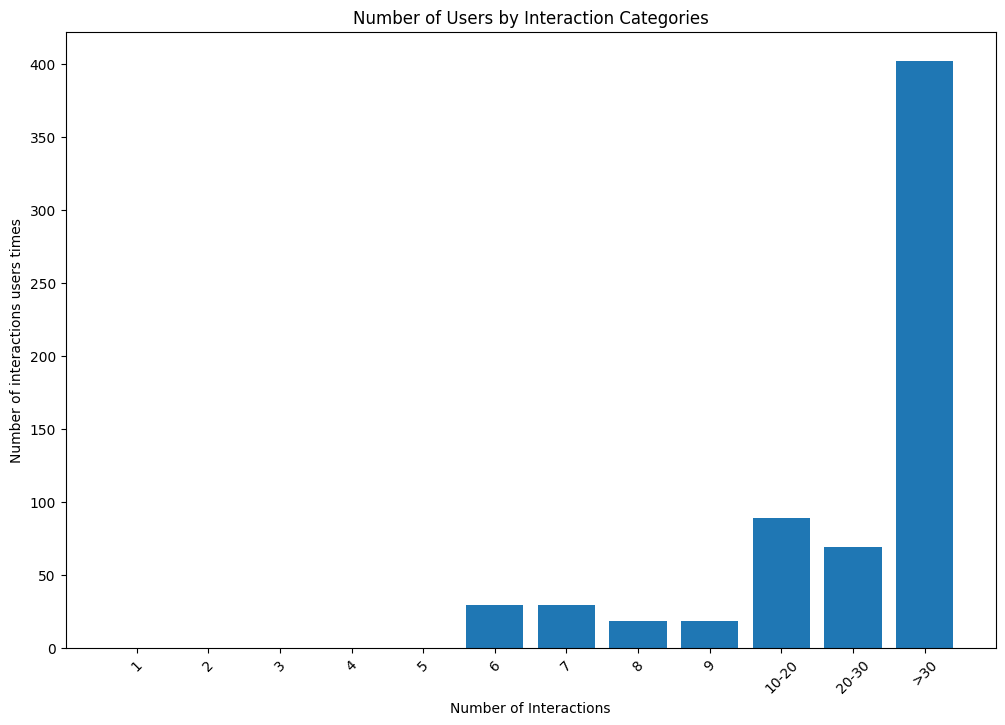

In [128]:
plot_by_inter(df_clean, user_column)

In [100]:
user_column = 'user'
ratings_column = 'rating'
item_column = 'item'

item_indx = get_element_idx_given_min_interactions(data, item_column, ratings_column, 5)
data_tmp = data[~item_indx]
user_indx = get_element_idx_given_min_interactions(data_tmp, user_column, ratings_column, 5)

# low_intercations = user_indx | item_indx

data_high_inter = data_tmp[~user_indx]

# data_high_inter.groupby('user')['cnt'].count()

In [104]:
data_high_inter.groupby('user')['cnt'].count().min(),
data_high_inter.groupby('item')['cnt'].count().min()

3

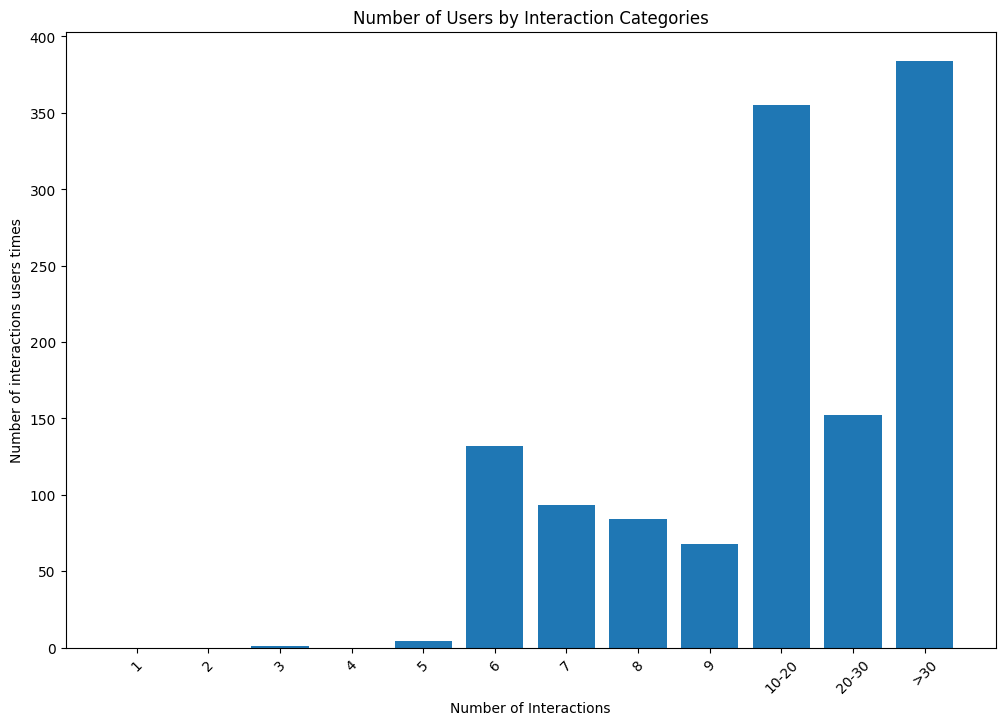

In [102]:
plot_by_inter(data_high_inter, item_column)

In [80]:
user_column = 'user'
ratings_column = 'rating'
item_column = 'item'

def get_idx_one_interactions(data, filter_column, ratings_column):
        data_groupedby_filter_column_interaction = data.groupby(filter_column)[
            [ratings_column]
        ].count()
        usersIds_one_interaction = list(
            data_groupedby_filter_column_interaction[
                data_groupedby_filter_column_interaction[ratings_column] == 1
            ].index
        )

        idx_few_interactions = np.isin(data[filter_column], usersIds_one_interaction)
        return idx_few_interactions

idx_user_one_interactions = get_idx_one_interactions(data,
    user_column, ratings_column
)
idx_item_one_interactions = get_idx_one_interactions(data,
    item_column, ratings_column
)

user_item_one_inter = idx_user_one_interactions | idx_item_one_interactions

data_tmp = data[~user_item_one_inter]


In [81]:
data_tmp.groupby('user').count()

,item,cnt,daytime,weekday,isweekend,homework,cost,weather,country,city,...,category,downloads,developer,icon,language,description,name,price,rating,short desc
user,,,,,,,,,,,,,,,,,,,,,
0,25,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,17
1,359,359,359,359,359,359,359,359,359,359,...,359,359,359,359,359,359,359,359,359,354
2,363,363,363,363,363,363,363,363,363,363,...,363,363,363,363,363,363,363,363,363,349
3,165,165,165,165,165,165,165,165,165,165,...,165,165,165,165,165,165,165,165,165,146
4,920,920,920,920,920,920,920,920,920,920,...,920,920,920,920,920,920,920,920,920,685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
945,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
946,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [91]:
def plot_by_inter(data_filtered_users, filter_column):

    interaction_counts_items = data_filtered_users.groupby(filter_column)["cnt"].size()

# Step 2: Define the bins and labels for the categories
    bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, np.inf]
    labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10-20", "20-30", ">30"]

# Step 3: Bin the data into the specified categories
    interaction_categories = pd.cut(
    interaction_counts_items, bins=bins, labels=labels, right=False
)

# Step 4: Count the number of users in each category
    category_counts = interaction_categories.value_counts().sort_index()

# Step 5: Plot
    plt.figure(figsize=(12, 8))
    plt.bar(category_counts.index, category_counts.values)
    plt.xlabel("Number of Interactions")
    plt.ylabel("Number of interactions users times")
    plt.title("Number of Users by Interaction Categories")
    plt.xticks(rotation=45)  # Improve readability of x-axis labels

    plt.show()



In [74]:
# data[~user_item_one_inter]
users_more_one_interaction = data[~user_item_one_inter].user.unique()
idx = []
for i in users_more_one_interaction:
    element = data[data["user"] == i].sample(n=1)
    idx.append(element.index[0])

test_idx = np.isin(data.index, np.array(idx))

train_ratings, test_ratings = (
    data[~test_idx],
    data[test_idx],
)

In [8]:
filter_column = 'user'
ratings_column = 'rating'
item_column = 'item'

frequency_interaction = data.groupby(filter_column)[[item_column, ratings_column]].count()
users_one_interaction = frequency_interaction[
    frequency_interaction[ratings_column] == 1
].index
list_of_users = data[filter_column].unique()
users_more_one_interaction = list(set(list_of_users) - set(users_one_interaction))
idx = []
for i in users_more_one_interaction:
    element = data[data["user"] == i].sample(n=1)
    idx.append(element.index[0])

test_idx = np.isin(data.index, np.array(idx))

train_ratings, test_ratings = (
    data[~test_idx],
    data[test_idx],
)

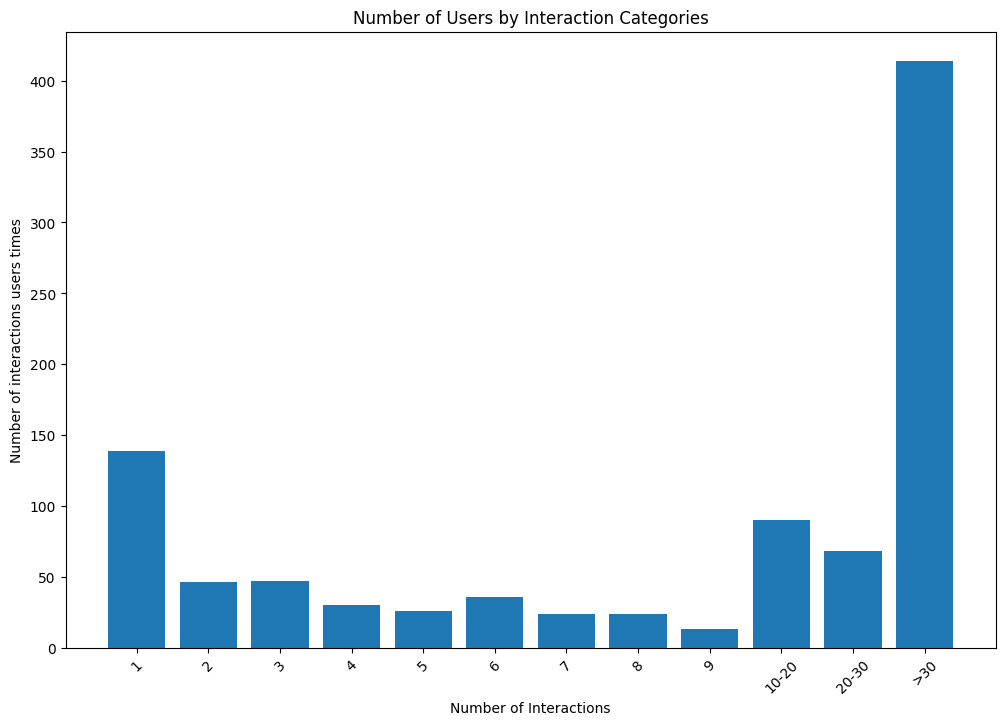

In [75]:
data_filtered_users = train_ratings
interaction_counts_items = data_filtered_users.groupby('user')['cnt'].size()

# Step 2: Define the bins and labels for the categories
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, np.inf]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10-20', '20-30', '>30']

# Step 3: Bin the data into the specified categories
interaction_categories = pd.cut(interaction_counts_items, bins=bins, labels=labels, right=False)

# Step 4: Count the number of users in each category
category_counts = interaction_categories.value_counts().sort_index()

# Step 5: Plot
plt.figure(figsize=(12, 8))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Number of Interactions')
plt.ylabel('Number of interactions users times')
plt.title('Number of Users by Interaction Categories')
plt.xticks(rotation=45)  # Improve readability of x-axis labels

plt.show()

In [ ]:
user_column = "user"
ratings_column = "rating"
item_column = "item"


def get_idx_low_interactions(data, filter_column, ratings_column):
    data_groupedby_filter_column_interaction = data.groupby(filter_column)[
        [ratings_column]
    ].count()
    usersIds_one_interaction = list(
        data_groupedby_filter_column_interaction[
            data_groupedby_filter_column_interaction[ratings_column] == 1
        ].index
    )

    idx_few_interactions = np.isin(data[filter_column], usersIds_one_interaction)
    return idx_few_interactions


idx_user_few_interactions_1 = get_idx_low_interactions(data,
    user_column, ratings_column
)

data[~idx_user_few_interactions_1]

In [64]:
idx_user_few_interactions_1 == idx_user_few_interactions
np.all(idx_user_few_interactions_1 == idx_user_few_interactions)

True

In [60]:
filter_column = 'user'
ratings_column = 'rating'
item_column = 'item'

data_groupedby_filter_column_interaction = data.groupby(filter_column)[
    [item_column, ratings_column]
].count()
usersIds_one_interaction = list(data_groupedby_filter_column_interaction[
    data_groupedby_filter_column_interaction[ratings_column] == 1
].index)
list_of_userIds = data[item_column].unique()
userIds_more_one_interaction = list(set(list_of_userIds) - set(usersIds_one_interaction))

idx_user_few_interactions = np.isin(data.user, usersIds_one_interaction)


In [52]:
np.array([True, False, False]) | np.array([False, True, False])

array([ True,  True, False])

In [ ]:
data[~idx_user_few_interactions | ~idx_items_few_interactions]

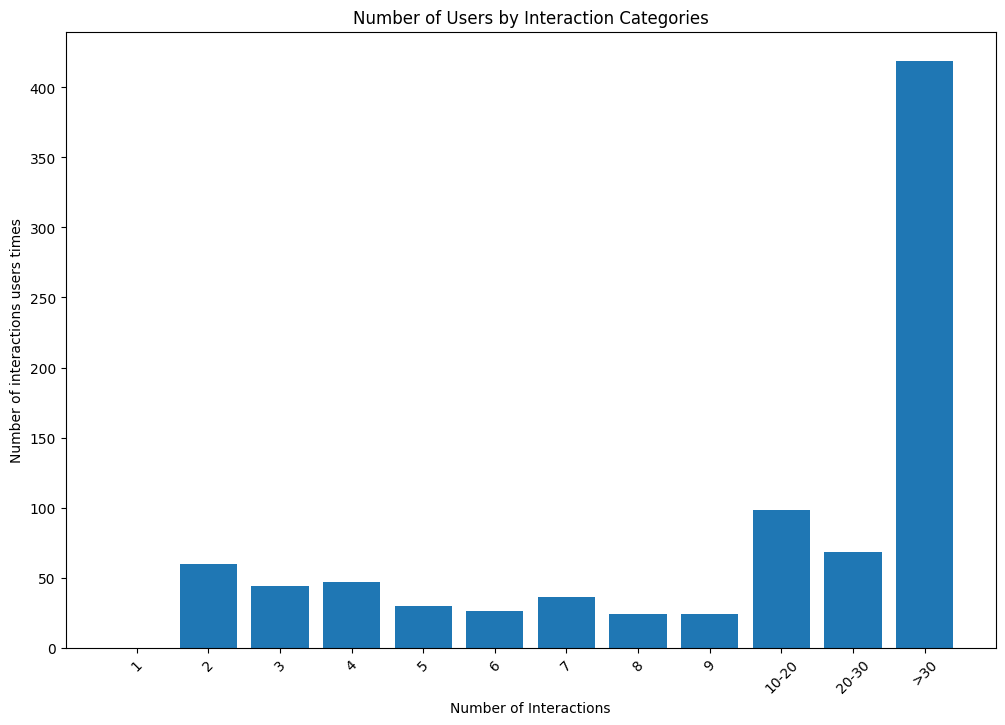

In [35]:
data_filtered_users = data[~idx_user_few_interactions]
interaction_counts_items = data_filtered_users.groupby('user')['cnt'].size()

# Step 2: Define the bins and labels for the categories
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, np.inf]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10-20', '20-30', '>30']

# Step 3: Bin the data into the specified categories
interaction_categories = pd.cut(interaction_counts_items, bins=bins, labels=labels, right=False)

# Step 4: Count the number of users in each category
category_counts = interaction_categories.value_counts().sort_index()

# Step 5: Plot
plt.figure(figsize=(12, 8))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Number of Interactions')
plt.ylabel('Number of interactions users times')
plt.title('Number of Users by Interaction Categories')
plt.xticks(rotation=45)  # Improve readability of x-axis labels

plt.show()

In [37]:
dt_tmp = data.copy()

In [54]:
data = dt_tmp

item_column = "item"
data_groupedby_item_interaction = data.groupby(item_column)[
    [filter_column, ratings_column]
].count()
itemIds_one_interaction = list(data_groupedby_item_interaction[
    data_groupedby_item_interaction[ratings_column] == 1
].index)
list_of_itemsId = data[item_column].unique()
itemsIds_more_one_interaction = list(set(list_of_itemsId) - set(itemIds_one_interaction))

idx_items_few_interactions = np.isin(data.item, itemIds_one_interaction)

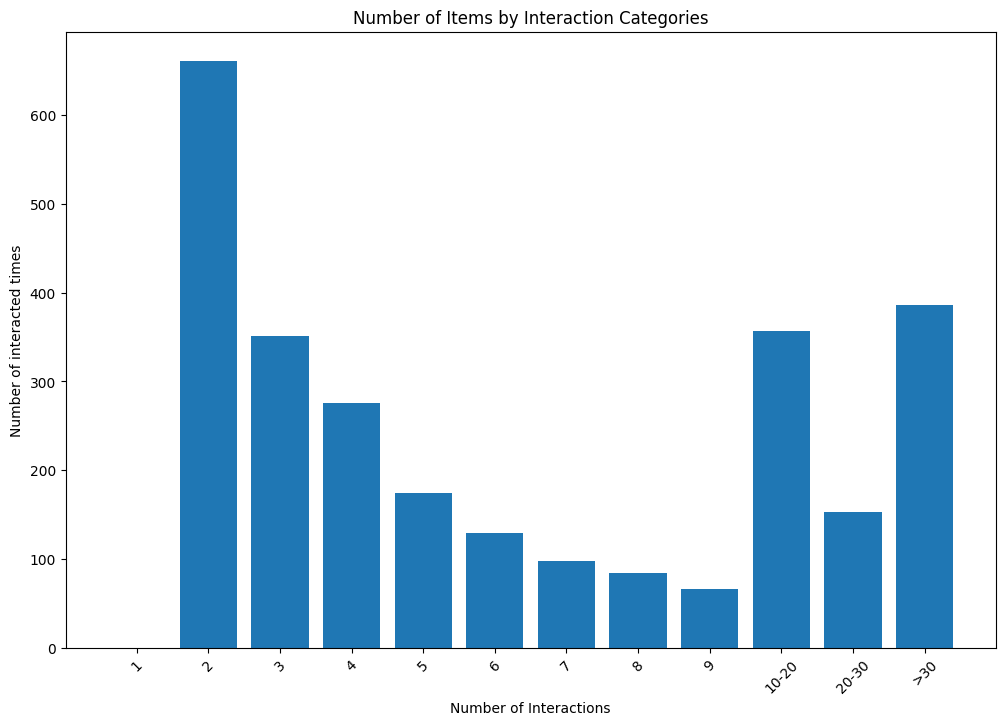

In [39]:
data_filtered_item = data[~idx_items_few_interactions]
interaction_counts_items = data_filtered_item.groupby('item')['cnt'].size()

# Step 2: Define the bins and labels for the categories
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, np.inf]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10-20', '20-30', '>30']

# Step 3: Bin the data into the specified categories
interaction_categories = pd.cut(interaction_counts_items, bins=bins, labels=labels, right=False)

# Step 4: Count the number of users in each category
category_counts = interaction_categories.value_counts().sort_index()

# Step 5: Plot
plt.figure(figsize=(12, 8))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Number of Interactions')
plt.ylabel('Number of interacted times')
plt.title('Number of Items by Interaction Categories')
plt.xticks(rotation=45)  # Improve readability of x-axis labels

plt.show()


In [ ]:

idx_items_one_inter = set()
for idx in items_one_interaction:
    element = data[data["item"] == i]
    idx_items_one_inter.update(set(element.index))
    # idx_items_one_inter.add(list(element.index))

len(idx_items_one_inter)


    # items_idx.append(element.index[0])
# data_clean = 
# for i in items_more_one_interaction:
#     element = data[data["item"] == i].sample(n=1)
#     items_idx.append(element.index[0])
# test_item_idx = np.isin(data.index, np.array(items_idx))

In [ ]:
def get_element_idx_given_min_interactions(df, min_interactions):
    data_groupedby_item_interaction = data.groupby(item_column)[
        [filter_column, ratings_column]
    ].count()
    itemIDs_one_interaction = data_groupedby_item_interaction[
        data_groupedby_item_interaction[ratings_column] <= min_interactions
    ].index

In [119]:
index_user_items_more_one_interaction = test_item_idx & test_idx

In [120]:
sum(index_user_items_more_one_interaction)

34

In [145]:
filter_column = 'user'
ratings_column = 'rating'

frequency_interaction = data.groupby(filter_column)[[item_column, ratings_column]].count()
users_one_interaction = frequency_interaction[
    frequency_interaction[ratings_column] == 1
].index
list_of_users = data[filter_column].unique()
users_more_one_interaction = list(set(list_of_users) - set(users_one_interaction))
idx = []

item_column = "item"
item_frequency_interaction = data.groupby(item_column)[
    [item_column, ratings_column]
].count()
items_one_interaction = item_frequency_interaction[
    item_frequency_interaction[ratings_column] == 1
].index
list_of_items = data[item_column].unique()
items_more_one_interaction = list(set(list_of_items) - set(items_one_interaction))

a = []
for i in users_more_one_interaction:
    element = data[data[filter_column] == i].sample(n=1)
    item_ID = element['item']
    print(item_ID.index[0])
    a.append(item_ID.index[0])
    break

    idx.append(element.index[0])

test_idx = np.isin(data.index, np.array(idx))

# train_ratings, test_ratings = (
#     data[~test_idx],
#     data[test_idx],
# )

65881


In [146]:
a

[65881]

In [134]:
items_one_interaction

Index([ 109,  130,  177,  182,  193,  217,  231,  235,  289,  406,
       ...
       4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081],
      dtype='int64', name='item', length=1345)

In [66]:
unique_item_ids = sorted(train_data.data[1].unique())
item_id_to_index = {item_id: index for index, item_id in enumerate(unique_item_ids)}
index_to_item_id = {index: item_id for item_id, index in item_id_to_index.items()}

In [67]:
unique_user_ids = sorted(train_data.data[0].unique())
user_id_to_index = {user_id: index for index, user_id in enumerate(unique_user_ids)}
index_to_user_id = {index: user_id for user_id, index in user_id_to_index.items()}

In [61]:
train_users = sorted(list(train_data.data[0]))
test_users = set(test_data.data[0])
elements = []
for i, element in enumerate(train_users):
  if i == len(train_users)-1:
    break
  if train_users[i+1] - element > 1:
    elements.append((element, train_users[i+1]))
len(set(train_users))

951

In [57]:
elements

[(284, 286), (774, 776), (854, 856), (875, 877), (915, 917), (941, 943)]

In [11]:
import torch
_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


for batch in train_loader:

  user_input = batch['user'].to(_device)
  item_input = batch['item'].to(_device)
  context_input = batch['context'].to(_device)
  ratings = batch['rating'].to(_device)

  model = train()
  break

In [12]:
user_input

tensor([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 12, 28, 29, 30, 31, 32, 33, 16, 34,
        35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 47, 49, 50, 51, 52, 53, 54,
        55, 39,  4, 56, 57,  2, 59, 60, 62, 63, 64, 65, 66, 32, 67, 69, 70, 13,
         2, 71, 72, 73, 74, 75, 76, 77, 34, 64, 65, 79, 80, 81, 39, 82,  1, 83,
         9, 85, 86, 87, 15, 88, 89, 32, 90, 33], device='cuda:0')

In [13]:
datapath = "../data/processed/frappeCtxA/frappeCtxA.test.rating"
df = pd.read_csv(datapath, sep='\t', header=None, )


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,58,25,4.1,0.301030,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,1,0
1,117,88,4.2,2.278754,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
2,202,177,4.0,0.477121,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
3,209,181,4.1,0.000000,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
4,318,305,4.5,0.000000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,439,60,4.3,0.477121,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
865,544,33,4.6,0.698970,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
866,109,16,3.6,1.903090,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0
867,345,110,4.3,0.000000,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,1,0


In [3]:
df_frappe.train_ratings.head()

,user,item,cnt,rating,daytime_afternoon,daytime_evening,daytime_morning,daytime_night,daytime_noon,daytime_sunrise,...,weather_sleet,weather_snowy,weather_stormy,weather_sunny,weather_unknown,isweekend_weekend,isweekend_workday,homework_home,homework_unknown,homework_work
0,0,0,0.000000,4.5,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
1,1,1,0.845098,4.2,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,2,2,0.778151,4.1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,3,3,0.000000,4.6,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
4,4,4,2.631444,4.5,0,0,0,1,0,0,...,0,0,0,1,0,0,1,1,0,0


In [6]:
df_frappe.save_data("frappeCtxA")

/home/alexabades/recsys/src/data/processed/frappeCtxA/frappeCtxA


In [45]:
import torch
data = df_frappe.train_ratings
data

,user,item,cnt,rating,daytime_afternoon,daytime_evening,daytime_morning,daytime_night,daytime_noon,daytime_sunrise,...,weather_sleet,weather_snowy,weather_stormy,weather_sunny,weather_unknown,isweekend_weekend,isweekend_workday,homework_home,homework_unknown,homework_work
0,0,0,0.000000,4.5,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
1,1,1,0.845098,4.2,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,2,2,0.778151,4.1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,3,3,0.000000,4.6,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
4,4,4,2.631444,4.5,0,0,0,1,0,0,...,0,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96196,45,5,1.431364,4.6,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
96198,110,0,0.698970,4.5,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
96199,37,16,2.004321,3.6,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
96200,181,33,2.385606,4.6,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [44]:
data['user'].loc[96196]

45

In [22]:
# TODO: user & item must be integer
user_item = list()
user_item_inter = df_frappe.train_ratings.shape
for row in df_frappe.train_ratings.iterrows():
  user = row[1]['user']
  item = row[1]['item']

  user_item.append((int(user), int(item)))
  
  

In [23]:
len(user_item), user_item_inter

(89181, (89181, 25))

In [24]:
user_item

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (7, 7),
 (8, 9),
 (9, 10),
 (10, 11),
 (11, 12),
 (12, 13),
 (13, 11),
 (14, 11),
 (15, 14),
 (16, 15),
 (17, 10),
 (18, 16),
 (19, 17),
 (20, 18),
 (21, 19),
 (22, 20),
 (23, 5),
 (24, 21),
 (25, 21),
 (26, 22),
 (27, 23),
 (12, 24),
 (28, 17),
 (29, 25),
 (30, 26),
 (31, 5),
 (32, 27),
 (33, 11),
 (16, 28),
 (34, 29),
 (35, 30),
 (38, 33),
 (39, 26),
 (40, 34),
 (42, 5),
 (43, 25),
 (44, 5),
 (45, 36),
 (46, 37),
 (47, 25),
 (47, 21),
 (49, 39),
 (50, 16),
 (51, 31),
 (52, 40),
 (53, 41),
 (54, 42),
 (55, 21),
 (39, 26),
 (4, 4),
 (56, 43),
 (57, 44),
 (58, 25),
 (2, 45),
 (59, 3),
 (60, 25),
 (62, 47),
 (63, 5),
 (64, 16),
 (65, 48),
 (66, 21),
 (32, 49),
 (67, 5),
 (69, 50),
 (70, 21),
 (13, 20),
 (2, 5),
 (71, 45),
 (72, 51),
 (73, 5),
 (74, 52),
 (75, 53),
 (76, 5),
 (77, 55),
 (34, 16),
 (64, 57),
 (65, 21),
 (79, 58),
 (80, 59),
 (81, 28),
 (39, 60),
 (82, 61),
 (1, 5),
 (83, 44),
 (9, 0),
 (85, 63),
 (86, 16),
 (87, 64),
 

In [266]:
class PreProcessData:
    def __init__(
        self,
        data_path: str = None,
        user_column: str = "user",
        item_column: str = "item",
        interaction_column: str = "cnt",
        sep: str = "\t",
    ):
        self.data_path = data_path
        self.user_column = user_column
        self.item_column = item_column
        self.interaction_column = interaction_column
        self.sep = sep
        self.rawData = self._load_data(datapath)
     

    def _load_data(self):
        return pd.read_csv(filepath_or_buffer=self.data_path, sep=self.sep)

In [297]:
df_meta

,user,item,cnt,daytime,weekday,isweekend,homework,cost,weather,country,...,category,downloads,developer,icon,language,description,name,price,rating,short desc
0,0,0,1,morning,sunday,weekend,unknown,free,sunny,United States,...,Productivity,"1,000,000 - 5,000,000",Any.DO,http://d2lh3rxs7crswz.cloudfront.net/com.anydo...,en,"Meet Any.DO, the best way to-do To-do's on And...",Any.DO To-do & Tasks List,Free,4.5,Any.DO helps you remember everything you have ...
1,1,1,7,afternoon,saturday,weekend,unknown,free,cloudy,Spain,...,News & Magazines,"1,000,000 - 5,000,000",Yahoo! Inc.,http://d2lh3rxs7crswz.cloudfront.net/com.yahoo...,en,"With Yahoo! for Android, you’ll stay connected...",Yahoo!,Free,4.2,"With Yahoo! for Android, you’ll stay connected..."
2,2,2,6,evening,monday,workday,unknown,free,cloudy,Spain,...,Tools,"1,000,000 - 5,000,000",Mobile Essentials,http://d2lh3rxs7crswz.cloudfront.net/com.compa...,en,Professional Compass for Android. Simple and p...,Compass PRO,Free,4.1,Professional Compass for Android. Simple and p...
3,3,3,1,sunset,thursday,workday,unknown,free,unknown,United States,...,Social,"50,000,000 - 100,000,000",Instagram,http://d2lh3rxs7crswz.cloudfront.net/com.insta...,en,Instagram – A beautiful way to share your worl...,Instagram,Free,4.6,Instagram – A beautiful way to share your worl...
4,4,4,428,night,thursday,workday,home,free,sunny,Switzerland,...,Shopping,"10,000 - 50,000",Kiwi3,http://d2lh3rxs7crswz.cloudfront.net/com.shopp...,en,Shopping List is the most easy way to organize...,Shopping List,Free,4.5,"The most easy Shopping List. In English, for f..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96198,110,0,5,evening,sunday,weekend,unknown,free,sunny,United States,...,Productivity,"1,000,000 - 5,000,000",Any.DO,http://d2lh3rxs7crswz.cloudfront.net/com.anydo...,en,"Meet Any.DO, the best way to-do To-do's on And...",Any.DO To-do & Tasks List,Free,4.5,Any.DO helps you remember everything you have ...
96199,37,16,101,sunset,sunday,weekend,unknown,free,cloudy,Canada,...,Social,"100,000,000 - 500,000,000",Facebook,http://d2lh3rxs7crswz.cloudfront.net/com.faceb...,en,"Keep up with friends, wherever you are with th...",Facebook,Free,3.6,"Keep up with friends, wherever you are with th..."
96200,181,33,243,afternoon,sunday,weekend,unknown,free,cloudy,Israel,...,Personalization,"1,000,000 - 5,000,000",TeslaCoil Software,http://d2lh3rxs7crswz.cloudfront.net/com.tesla...,en,"Highly customizable, performance driven, home ...",Nova Launcher,Free,4.6,NaN
96201,451,752,1,evening,sunday,weekend,unknown,free,sunny,United States,...,Social,"1,000,000 - 5,000,000",groupme,http://d2lh3rxs7crswz.cloudfront.net/com.group...,en,GroupMe is the best way to chat with everyone ...,GroupMe,Free,4.4,GroupMe is the best way to chat with everyone ...


In [293]:
from typing import List
from pandas import DataFrame

class PreProcessDataNCFContextual:
    def __init__(
        self,
        path: str,
        data_file: str = "frappe.csv",
        meta_file: str = "meta.csv",
        user_column: str = "user",
        item_column: str = "item",
        ctx_categorical_columns: List[str] = ["daytime",  "weather", "isweekend", "homework"],
        ctx_numerical_columns: List[str] = ["cnt"],
        ratings_colum: str = "rating",
        sep: str = "\t",
    ) -> None:
        # super().__init__(path, user_column, item_column, interaction_column=None, sep=sep)
        self.path = path
        
        self.columns = self._clean_columns(
            user_column,
            item_column,
            ctx_categorical_columns,
            ctx_numerical_columns,
            ratings_colum,
        )
        self.rawData = self._load_data(path + data_file, sep)
        self.rawMeta = self._load_data(path + meta_file, sep)
        self.data = self.create_data(ratings_colum, item_column, ctx_categorical_columns, ctx_numerical_columns)

    def _load_data(self, data_path, sep):
        return pd.read_csv(data_path, sep=sep)

    def _merge_data(self, data, metadata, item_column):
        dataframe = data.merge(metadata, on=item_column)
        return dataframe

    def _clean_columns(self, *args):
        clean_columns = []
        for i in args:
            if isinstance(i, str):
                clean_columns.append(i)
                continue
            clean_columns.extend(i)
        return clean_columns

    def create_data(self, ratings_colum:str, item_column:str, ctx_categorical_columns:List[str], ctx_numerical_columns:List[str])->DataFrame:
        data = self._merge_data(self.rawData, self.rawMeta, item_column)[self.columns]
        data = self.clear_ratings(data, ratings_colum)
        data = self.log_numerical(data, ctx_numerical_columns)
        data = self.binarize_nominal_features(data, ctx_categorical_columns)
        return data

    def clear_ratings(self, df: DataFrame, rating_column:str) -> DataFrame:
        df[rating_column] = pd.to_numeric(df[rating_column], errors='coerce')
        df = df.dropna(subset=[rating_column])
        return df

    def log_numerical(self, df:DataFrame, numerical_features: List[str])->DataFrame:
        df_tmp = df.copy()
        for feature in numerical_features:
            df_tmp[feature]=df_tmp[feature].apply(lambda x: np.log10(x) if x != 0 else np.log10(x + 1))
        return df_tmp


    def binarize_nominal_features(self, df:DataFrame, contextual_features:List[str])->DataFrame:
        df_bin = pd.get_dummies(df, columns=contextual_features, dtype=int)
        return df_bin

In [294]:
data = PreProcessDataNCFContextual(datapath)
data.data

,user,item,cnt,rating,daytime_afternoon,daytime_evening,daytime_morning,daytime_night,daytime_noon,daytime_sunrise,...,weather_sleet,weather_snowy,weather_stormy,weather_sunny,weather_unknown,isweekend_weekend,isweekend_workday,homework_home,homework_unknown,homework_work
0,0,0,0.000000,4.5,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
1,1,1,0.845098,4.2,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,2,2,0.778151,4.1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,3,3,0.000000,4.6,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
4,4,4,2.631444,4.5,0,0,0,1,0,0,...,0,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96198,110,0,0.698970,4.5,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
96199,37,16,2.004321,3.6,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
96200,181,33,2.385606,4.6,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
96201,451,752,0.000000,4.4,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0


In [265]:
import os

folder_path = "../data/raw/frappe/"

# List everything in the folder
items = os.listdir(folder_path)

# If you want only files, you can filter the list using os.path.isfile
files = [item for item in items if os.path.isfile(os.path.join(folder_path, item))]

print(files)


['meta.csv', '.DS_Store', 'frappe.csv', 'README.txt']


In [261]:
data = PreProcessDataNCFContextual(datapath)

KeyError: "['rating'] not in index"

In [259]:
data.rawData

,user,item,cnt,daytime,weekday,isweekend,homework,cost,weather,country,city
0,0,0,1,morning,sunday,weekend,unknown,free,sunny,United States,0
1,1,1,7,afternoon,saturday,weekend,unknown,free,cloudy,Spain,0
2,2,2,6,evening,monday,workday,unknown,free,cloudy,Spain,369
3,3,3,1,sunset,thursday,workday,unknown,free,unknown,United States,1028
4,4,4,428,night,thursday,workday,home,free,sunny,Switzerland,147
...,...,...,...,...,...,...,...,...,...,...,...
96198,110,0,5,evening,sunday,weekend,unknown,free,sunny,United States,0
96199,37,16,101,sunset,sunday,weekend,unknown,free,cloudy,Canada,128
96200,181,33,243,afternoon,sunday,weekend,unknown,free,cloudy,Israel,454
96201,451,752,1,evening,sunday,weekend,unknown,free,sunny,United States,0


In [3]:
d._binarize_data()

In [4]:
d.split_traintest()

In [5]:
d.negative_samples()

In [6]:
d.save_data("frappe")

/home/alexabades/recsys/src/data/processed/frappe/frappe


In [5]:
d.ratings.head()

,user,item,cnt
0,0,0,1
1,1,1,1
2,2,2,1
3,3,3,1
4,4,4,1


In [5]:
df = d.ratings
frequency_interaction = df.groupby("user")[["item", "cnt"]].count()
users_one_interaction = frequency_interaction[frequency_interaction["cnt"]==1].index
# df_users_one_interacation = df[df['user'].isin(users_one_interaction)]
list_of_users = users = df["user"].unique()
users_more_one_interaction = list(set(list_of_users)-set(users_one_interaction))

idx = []
for i in users_more_one_interaction:
  element = df[df["user"] == i ].sample(n=1)
  idx.append(element.index[0])

test_idx = np.isin(df.index, np.array(idx))
df_test = df[test_idx]

In [31]:
set_of_items = set(df["item"].unique())
len(set_of_items)

4082

In [18]:
seen_items_by_user = df.groupby('user')['item'].apply(set).to_dict()

In [44]:
import random
K = 10 
set_of_items = set(df["item"].unique())
seen_items_by_user = df.groupby('user')['item'].apply(set).to_dict()

negative_samples = []
for row in df_test.iterrows():
  
  user = row[1]["user"]
  item = row[1]["item"]
  unseen_items = list(set_of_items - seen_items_by_user.get(user, set()))
  random_elements = random.sample(unseen_items, K)

  # Ensure there are at least K unseen items
  if len(unseen_items) < K:
      raise ValueError(f"User {user} does not have enough unseen items to select {K} random elements.")
  
  random_elements = random.sample(unseen_items, K)
  
  # Append to csv_rows
  negative_samples.append([(user, item)] + random_elements)
  


In [7]:
len(list(d.ratings["user"])), len(set(d.ratings["user"]))

(96203, 957)

In [75]:
frequency_interaction = df.groupby("user")[["item", "cnt"]].count()
users_one_interaction = frequency_interaction[frequency_interaction["cnt"]==1].index
# df_users_one_interacation = df[df['user'].isin(users_one_interaction)]
list_of_users = users = df["user"].unique()
users_more_one_interaction = list(set(list_of_users)-set(users_one_interaction))

idx = []
for i in users_more_one_interaction:
  element = df[df["user"] == i ].sample(n=1)
  idx.append(element.index[0])

boolean_array = np.isin(df.index, np.array(idx))

In [72]:
df_users_one_interacation

,user,item,cnt,daytime,weekday,isweekend,homework,cost,weather,country,city
595,285,56,6,morning,tuesday,workday,unknown,free,sunny,United States,0
859,336,5,2,evening,friday,weekend,unknown,free,unknown,unknown,0
2105,455,25,13,morning,monday,workday,unknown,free,unknown,unknown,0
2121,456,121,1,afternoon,friday,workday,unknown,paid,rainy,United States,0
3135,517,16,1,morning,wednesday,workday,unknown,free,cloudy,Cyprus,0
...,...,...,...,...,...,...,...,...,...,...,...
91581,952,21,1,morning,monday,workday,unknown,free,cloudy,United Kingdom,0
93159,953,17,6,night,thursday,workday,unknown,free,unknown,unknown,0
93600,954,39,2,evening,friday,weekend,unknown,free,sunny,Germany,0
94517,955,33,2,morning,wednesday,workday,unknown,free,sunny,United States,996


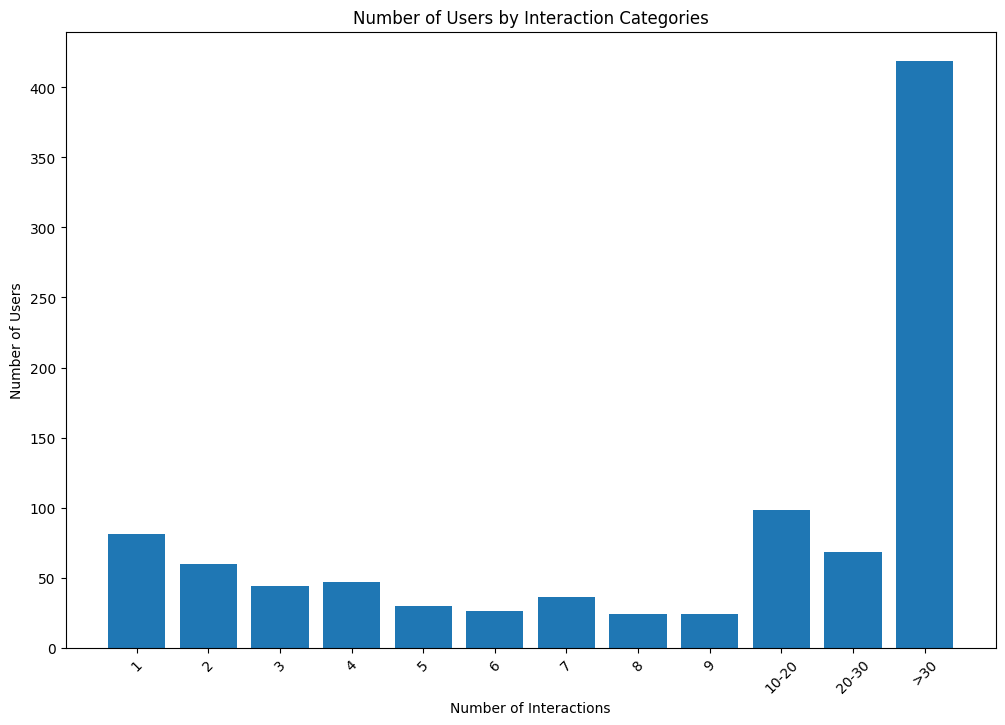

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame and 'cnt' is the column with the count of interactions

# Step 1: Calculate interaction counts per user
interaction_counts = df.groupby('user')['cnt'].size()

# Step 2: Define the bins and labels for the categories
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, np.inf]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10-20', '20-30', '>30']

# Step 3: Bin the data into the specified categories
interaction_categories = pd.cut(interaction_counts, bins=bins, labels=labels, right=False)

# Step 4: Count the number of users in each category
category_counts = interaction_categories.value_counts().sort_index()

# Step 5: Plot
plt.figure(figsize=(12, 8))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.title('Number of Users by Interaction Categories')
plt.xticks(rotation=45)  # Improve readability of x-axis labels

plt.show()

# category_counts.to_csv("frequency_intercation.csv")

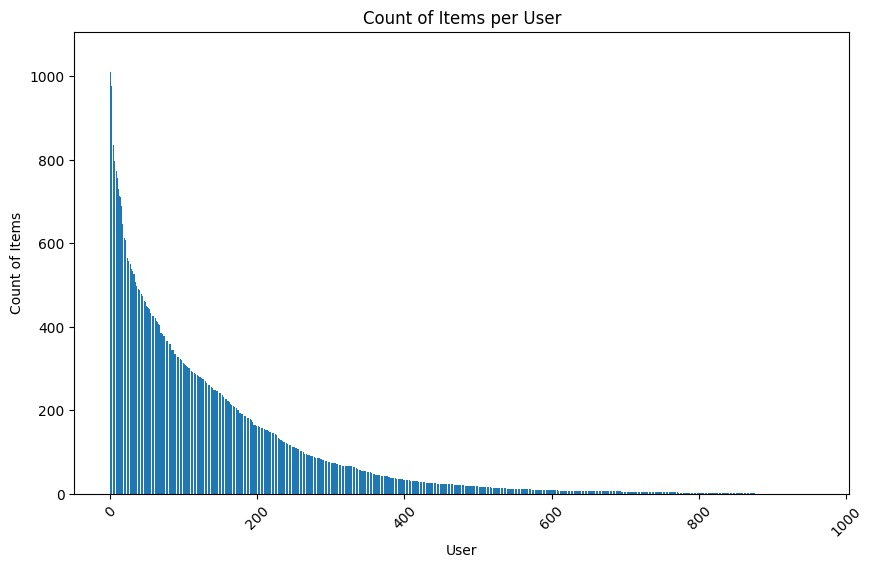

In [183]:
user_interactions_sorted = df.groupby("user")["cnt"].count().sort_values(ascending=False)
sorted_counts_df = user_interactions_sorted.reset_index()
sorted_counts_df.columns = ['User', 'Count of Items'] 
# sorted_counts_df.to_csv("user_interactions_count.csv")


plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_counts_df)), sorted_counts_df['Count of Items'])
plt.xlabel('User')
plt.ylabel('Count of Items')
plt.title('Count of Items per User')
plt.xticks(rotation=45)  # Rotate for better label readability
plt.show()

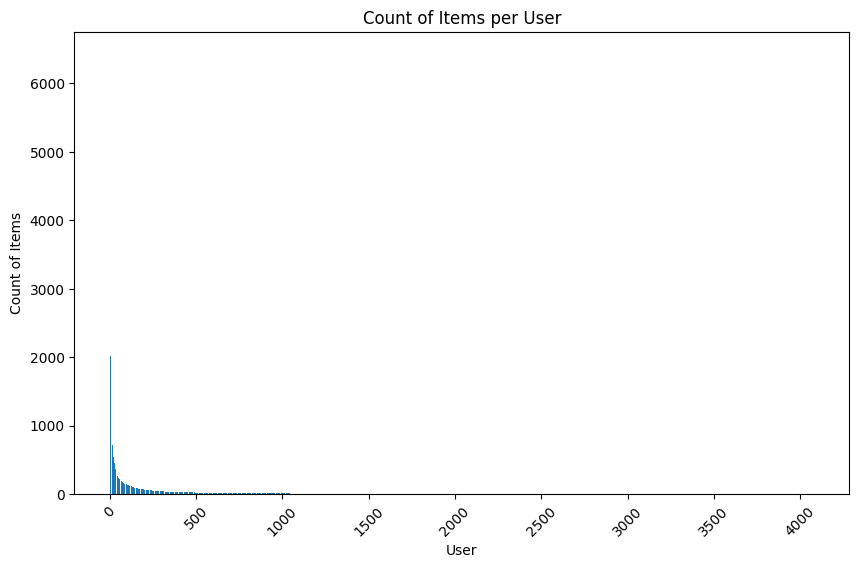

In [181]:
item_interactions_sorted = df.groupby("item")["cnt"].count().sort_values(ascending=False)
sorted_counts_df = item_interactions_sorted.reset_index()
sorted_counts_df.columns = ['Item', 'Count of users'] 
# sorted_counts_df.to_csv("item_interactions_count.csv")


plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_counts_df)), sorted_counts_df['Count of users'])
plt.xlabel('User')
plt.ylabel('Count of Items')
plt.title('Count of Items per User')
plt.xticks(rotation=45)  # Rotate for better label readability
plt.show()

In [ ]:

import matplotlib.pyplot as plt

# Assuming sorted_counts is the result from the previous operation

plt.figure(figsize=(10, 6)) # Adjust the figure size as needed
plt.bar(sorted_counts_df.index, sorted_counts_df.values)
plt.xlabel('User') # Label for the x-axis
plt.ylabel('Count of Items') # Label for the y-axis
plt.title('Count of Items per User') # Title of the plot
plt.xticks(rotation=45) # Rotate the x-axis labels for better readability if needed
plt.show()

In [3]:
datapath = "../data/raw/frappe/"
meta_app = pd.read_csv(datapath +'meta.csv', sep="\t")
df_meta = df.merge(meta_app, on='item')
print(list(meta_app.columns))

['item', 'package', 'category', 'downloads', 'developer', 'icon', 'language', 'description', 'name', 'price', 'rating', 'short desc']


In [90]:
for element in meta_app.columns:
  print(element + " : " , len(meta_app[element].unique()))

item :  4082
package :  3533
category :  32
downloads :  16
developer :  2809
icon :  3533
language :  29
description :  3520
name :  3509
price :  141
rating :  197
short desc :  2549


In [101]:
meta_app.price.unique()

array(['Free', 'unknown', '$2.06', '$3.18', '$4.78', '$0.99', '$1.9',
       '$3.07', '$2.38', '$14.95', '$3.11', '$4.13', '$1.2', '$2.99',
       '$2.66', '$1.99', '$2.86', '$1.97', '$4.99', '$1.98', '$2.96',
       '$2.45', '$16.8', '$5.99', '$2.34', '$2.97', '$5.78', '$2.09',
       '$15.99', '$4.95', '$1.03', '$5.37', '$3.99', '$4.08', '$14.99',
       '$2.16', '€\xa00,99', '€\xa03,59', '$6.19', '$4.41', '$3.29',
       '$3.44', '€\xa03,00', '$4.64', '$2', '$1.29', '$3.1', '$6.02',
       '$3.56', '$3.68', '$5.34', '$3.82', '$15.09', '$2.9', '$5.35',
       '83,13\xa0руб.', '$5.56', '$1.53', '$0.98', '$2.3', '$18.16',
       '$3.09', '$1.59', '$3.49', '$9.99', '$6.49', '$2.7', '3,99\xa0€',
       '$1.14', '$7.99', '$9.21', '$2.79', '$0.92', '$3.45', '$1.61',
       '$1.07', '$1.11', '$2.08', '$2.15', '$3.78', '$3.94', '$0.96',
       '$1.49', '$10.01', '$1.71', '$6.99', '$2.39', '$1.93', '$2.05',
       '$3', '$4.75', '$1.78', '$2.6', '$3.39', '$4.91', '$1.06', '$2.51',
       '$1.

In [12]:
dt = PreProcessData(datapath + 'frappe.csv')

In [9]:
df.isweekend.unique()

array(['weekend', 'workday'], dtype=object)

In [34]:
len(meta_app.iloc[0]), len(df.iloc[0])

(12, 11)

In [15]:
len(df_meta.iloc[0]), df_meta.iloc[0]

(22,
 user                                                           0
 item                                                           0
 cnt                                                            1
 daytime                                                  morning
 weekday                                                   sunday
 isweekend                                                weekend
 homework                                                 unknown
 cost                                                        free
 weather                                                    sunny
 country                                            United States
 city                                                           0
 package                                                com.anydo
 category                                            Productivity
 downloads                                  1,000,000 - 5,000,000
 developer                                                 Any.DO
 icon

In [47]:
df_test = df[["user", "item", "isweekend", "weather"]].copy()


In [48]:

df_encoded = pd.get_dummies(df_test, columns=['isweekend', "weather"], dtype=int)

In [49]:
df_encoded

,user,item,isweekend_weekend,isweekend_workday,weather_cloudy,weather_drizzle,weather_foggy,weather_rainy,weather_sleet,weather_snowy,weather_stormy,weather_sunny,weather_unknown
0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,1,1,1,0,1,0,0,0,0,0,0,0,0
2,2,2,0,1,1,0,0,0,0,0,0,0,0
3,3,3,0,1,0,0,0,0,0,0,0,0,1
4,4,4,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96198,110,0,1,0,0,0,0,0,0,0,0,1,0
96199,37,16,1,0,1,0,0,0,0,0,0,0,0
96200,181,33,1,0,1,0,0,0,0,0,0,0,0
96201,451,752,1,0,0,0,0,0,0,0,0,1,0


In [29]:
daytime = [i for i in df_meta["daytime"].unique()]
weekday = [i for i in df_meta["weekday"].unique()]
weather= [i for i in df_meta["weather"].unique()]

In [39]:
daytime

['morning', 'afternoon', 'evening', 'sunset', 'night', 'noon', 'sunrise']

In [31]:
print("daytime, " , len(daytime), " Context features")
print("weekday, " , len(weekday), " Context features")
print("weather, " , len(weather), " Context features")
print("Total: ", len(daytime) + len(weekday)+ len(weather))

daytime,  7  Context features
weekday,  7  Context features
weather,  9  Context features
Total:  23


In [35]:
print(" Number of contextual features: ",len(df_meta.iloc[0]))

 Number of contextual features:  22


In [43]:
for column in df_meta.columns:
  print(f"{column} has {len(df_meta[column].unique())} unique values")

user has 957 unique values
item has 4082 unique values
cnt has 1981 unique values
daytime has 7 unique values
weekday has 7 unique values
isweekend has 2 unique values
homework has 3 unique values
cost has 2 unique values
weather has 9 unique values
country has 80 unique values
city has 233 unique values
package has 3533 unique values
category has 32 unique values
downloads has 16 unique values
developer has 2809 unique values
icon has 3533 unique values
language has 29 unique values
description has 3520 unique values
name has 3509 unique values
price has 141 unique values
rating has 197 unique values
short desc has 2549 unique values


In [217]:
from typing import List

datapath = "../data/raw/frappe/frappe.csv"
df = pd.read_csv(datapath, sep="\t")
# d = PreProcessData(datapath)
datapath = "../data/raw/frappe/"
meta_app = pd.read_csv(datapath +'meta.csv', sep="\t")
df_meta = df.merge(meta_app, on='item')

def clear_ratings(df, rating_column:str='rating'):
  df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
  df = df.dropna(subset=['rating'])
  return df

def log_numerical(df, numerical_features: List[str] = ["cnt"]):
  df_tmp = df.copy()
  for feature in numerical_features:
      df_tmp['cnt']=df_tmp['cnt'].apply(lambda x: np.log10(x) if x != 0 else np.log10(x + 1))
  return df_tmp


def binarize_nominal_features(df, contextual_features:List[str]=['isweekend', 'weather', 'daytime']):
  df_bin = pd.get_dummies(df, columns=contextual_features, dtype=int)
  return df_bin


In [218]:
data = clear_ratings(df_meta)

In [219]:
data = log_numerical(data)

In [222]:
data = binarize_nominal_features(data)

In [241]:
def _clean_columns(*args):
    clean_columns = []
    for i in args:
        if isinstance(i, str):
            clean_columns.append(i)
            continue
        clean_columns.extend(i)
    return clean_columns

In [245]:
_clean_columns(cols, user, numerical, item, ratings)

['isweekend', 'weather', 'daytime', 'user', 'cnt', 'item', 'rating']

In [243]:
cols = ['isweekend', 'weather', 'daytime']
numerical = ['cnt']
ratings = ['rating']
user = 'user'
item = 'item'

In [192]:
isinstance(4.5, int)

False

In [201]:
import numpy 
lst = []
for i in df['cnt'].unique():
  # print(i), print(type(i)), print(isinstance(i, numpy.int64))
  if not isinstance(i, numpy.int64):
    lst.append(i)

In [203]:
df['cnt'].apply(lambda x: np.log10(x) if x != 0 else np.log10(x + 1))

0        0.000000
1        0.845098
2        0.778151
3        0.000000
4        2.631444
           ...   
96198    0.698970
96199    2.004321
96200    2.385606
96201    0.000000
96202    0.477121
Name: cnt, Length: 96203, dtype: float64

In [209]:
df_meta['cnt']=df_meta['cnt'].apply(lambda x: np.log10(x) if x != 0 else np.log10(x + 1))

In [152]:
df_tmp['rating'] = pd.to_numeric(df_tmp['rating'], errors='coerce')

df_cleaned = df_tmp.dropna(subset=['rating'])
df_cleaned.shape

(90050, 22)

In [143]:
df_tmp.shape

(96203, 22)

In [51]:
[a for a in range(1) if a < 0]

[]

In [60]:
df_meta['rating'].dtype
# type(df['weekday'].iloc[0])

dtype('O')

In [61]:
df_meta_test = df_meta.copy()

In [90]:
c = 0
for row in df_meta.iterrows():
  rating = row[1]['rating']
  if rating == 'unknown':
    c += 1
  
c

6153

In [62]:
df_meta_test['rating'] = pd.to_numeric(df_meta_test['rating'], errors='coerce')

In [71]:
df_meta_test['rating']
sum(df_meta_test['rating'].isna())

6153

In [96]:
import math
df_meta_test['cnt'].max(), math.log10(df_meta_test['cnt'].max())

(28752, 4.458668059764898)

In [116]:
# df_meta_test[['cnt']] = df_meta_test[['cnt']].apply(lambda x : math.log10(x))
df_meta_test['cnt']

0        0.000000
1        0.845098
2        0.778151
3        0.000000
4        2.631444
           ...   
96198    0.698970
96199    2.004321
96200    2.385606
96201    0.000000
96202    0.477121
Name: cnt, Length: 96203, dtype: float64

In [112]:
for i in df_meta_test.iterrows():
  
  if not isinstance(i[1]['cnt'], int):
    print(i[1]['cnt'])
  